In [61]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import torch
import numpy as np
from os import environ
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pickle as pkl
from astropy.wcs import WCS
from bliss.surveys.sdss import SloanDigitalSkySurvey
import pandas as pd

from bliss.surveys.sdss import PhotoFullCatalog, SloanDigitalSkySurvey
from bliss.catalog import FullCatalog
from bliss.predict import prepare_image
from bliss.metrics import BlissMetrics, MetricsMode
from bliss.catalog import TileCatalog

from hydra import initialize, compose
from hydra.utils import instantiate
import copy

In [3]:
environ["BLISS_HOME"] = str(Path().resolve().parents[1])
with initialize(config_path=".", version_base=None):
    cfg = compose("config")

cfg.prior.mean_sources = 0.02

## Getting data

In [51]:
sim = instantiate(cfg.simulator)

/home/sawanpa/bliss/.venv/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [52]:
tc = sim.catalog_prior.sample()
image_ids, image_id_indices = sim.randomized_image_ids(sim.catalog_prior.batch_size)
images, background, deconv, psf_params = sim.simulate_image(
    tc, image_ids, image_id_indices
)

In [6]:
tile_cat = tc.to_dict()

In [53]:
fc = tc.to_full_params()

### Input transform bar plot

In [54]:
model_names = ["log_transform_conv_3d_1e-5_v2", "vectorized_rolling_z", "realigned_log_conv_3d_CLAHE_1e-5", "zscore_conv3d"]
flags = [["log_transform"], ["rolling_z_score"], ["log_transform", "clahe"], ["z_score"]]
model_preds = {}
model_shorthand = ["log_conv_3d", "10x10_rolling_z", "log_clahe_conv_3d", "80x80_z"]
for i in range(len(model_shorthand)):
    model_preds[model_shorthand[i]] = {"metrics": {}, "flags": flags[i], "filename": model_names[i], "est_cat": None}


In [33]:
cfg.encoder.input_transform_params

{'use_deconv_channel': False, 'concat_psf_params': False, 'log_transform': False, 'rolling_z_score': True, 'z_score': False, 'clahe': False}

In [55]:
def pred(model_preds, cfg, data_dir, tile_cat, images, background):
    conf = cfg.copy()
    for _, settings in model_preds.items():
        imgs = copy.deepcopy(images)
        bgs = copy.deepcopy(background)
        tc = copy.deepcopy(tile_cat)
        tfs = conf.encoder.input_transform_params
        for tf in tfs.keys():
            tfs[tf] = (tf in settings['flags'])
        conf.predict.weight_save_path = data_dir + f"{settings['filename']}.pt"
        encoder = instantiate(conf.encoder)
        enc_state_dict = torch.load(conf.predict.weight_save_path)
        encoder.load_state_dict(enc_state_dict)
        encoder.eval()
        batch = {"images": imgs, "background": bgs}
        true_tile_cat = tc.symmetric_crop(encoder.tiles_to_crop)
        pred = encoder.encode_batch(batch)
        est_tile_cat = encoder.variational_mode(pred, return_full=False)
        metrics = encoder.metrics(true_tile_cat, est_tile_cat)
        settings['metrics'] = metrics
        settings['est_cat'] = est_tile_cat
    return model_preds

In [56]:
data_dir = "/data/scratch/sawanpa/paper_models/"
imgs = copy.deepcopy(images)
bgs = copy.deepcopy(background)
tile_cat = copy.deepcopy(tc)
p = pred(model_preds, cfg, data_dir, tile_cat, imgs, bgs)

In [48]:
p.keys()

dict_keys(['log_conv_3d', '10x10_rolling_z', 'log_clahe_conv_3d', '80x80_z'])

In [62]:
p['80x80_z']['metrics']['f1']

0.7349926829338074

In [44]:
list(p['80x80_z']['est_cat'].keys())

['star_fluxes', 'source_type', 'galaxy_params', 'galaxy_fluxes']

In [97]:
fluxes = p['log_conv_3d']['est_cat']['star_fluxes'][0, :, :, 0, 2] + p['log_conv_3d']['est_cat']['galaxy_fluxes'][0, :, :, 0, 2]

In [72]:
mask = tc.n_sources[0, 1:-1, 1:-1]

In [95]:
true_fluxes = mask*tc['star_fluxes'][0, 1:-1, 1:-1, 0, 2] + mask*tc['galaxy_fluxes'][0, 1:-1, 1:-1, 0, 2]

In [87]:
fluxes.shape

torch.Size([18, 18])

In [98]:
((true_fluxes - fluxes) / true_fluxes).nanmean()

tensor(0.48109, dtype=torch.float64, grad_fn=<DivBackward0>)

In [59]:
fluxes.max()

tensor(57716.96875, grad_fn=<MaxBackward1>)

In [194]:
transform_fig = ['Log', 'Log + CLAHE', '80x80 Window Z-Score', '10x10 Rolling Z-Score']

In [195]:
m = {'Model': transform_fig, 'Val/Loss': np.array([0.8962, 0.8247, 0.7612, 0.773], dtype=float), 'Test/Loss': np.array([0.8997, 0.8399, 0.7663, 0.8073], dtype=float), 'Test/Avg_Distance': np.array([1.053, 1.037, 0.7991, 0.8778], dtype=float), 'Test/(1 - F1)': 1 - np.array([0.8098, 0.8169, 0.8438, 0.8249], dtype=float), 'Flux Residual Error': np.array([0.48109, 0.29274, 0.54760, 0.33670])}
# m = torch.load('data/scratch/sawanpa/paper_models/input_transform_metrics.pt')
# m = {'Test/Loss': np.array([0.8997, 0.8399, 0.7663, 0.8073], dtype=float), 'Val/Loss': np.array([0.8962, 0.8247, 0.7612, 0.773], dtype=float), 'Test/F1': np.array([0.8098, 0.8169, 0.8438, 0.8249], dtype=float), 'Test/Avg_Distance': np.array([1.053, 1.037, 0.7991, 0.8778], dtype=float)}

In [68]:
transform_fig

{'log_transform': {'Test/Loss': 0.8997,
  'Val/Loss': 0.8962,
  'Test/F1': 0.8098,
  'Test/Avg_Distance': 1.053},
 'log_clahe': {'Test/Loss': 0.8399,
  'Val/Loss': 0.8247,
  'Test/F1': 0.8169,
  'Test/Avg_Distance': 1.037},
 '80x80_zscore': {'Test/Loss': 0.7663,
  'Val/Loss': 0.7612,
  'Test/F1': 0.8438,
  'Test/Avg_Distance': 0.7991},
 '10x10_rolling_z_score': {'Test/Loss': 0.8073,
  'Val/Loss': 0.773,
  'Test/F1': 0.8249,
  'Test/Avg_Distance': 0.8778}}

In [196]:
df = pd.DataFrame(data=m, columns=m.keys())

In [197]:
df.set_index("Model")

,Val/Loss,Test/Loss,Test/Avg_Distance,Test/(1 - F1),Flux Residual Error
Model,,,,,
Log,0.8962,0.8997,1.0530,0.1902,0.48109
Log + CLAHE,0.8247,0.8399,1.0370,0.1831,0.29274
80x80 Window Z-Score,0.7612,0.7663,0.7991,0.1562,0.54760
10x10 Rolling Z-Score,0.7730,0.8073,0.8778,0.1751,0.33670


In [198]:
z = df[['Model', 'Val/Loss', 'Test/Loss']]

In [199]:
z = z.melt('Model', var_name='Metrics', value_name='Loss')

In [104]:
z

,Model,Metrics,Loss
0,Log,Val/Loss,0.8962
1,Log + CLAHE,Val/Loss,0.8247
2,80x80 Window Z-Score,Val/Loss,0.7612
3,10x10 Rolling Z-Score,Val/Loss,0.7730
4,Log,Test/Loss,0.8997
5,Log + CLAHE,Test/Loss,0.8399
6,80x80 Window Z-Score,Test/Loss,0.7663
7,10x10 Rolling Z-Score,Test/Loss,0.8073


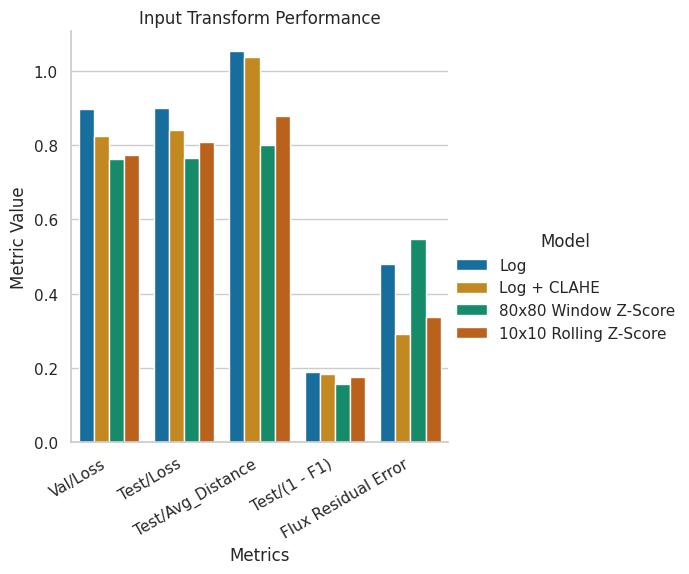

In [169]:
z = df.melt('Model', var_name='Metrics', value_name='Metric Value')
g = sns.catplot(x='Metrics', y='Metric Value', hue='Model', data=z, kind='bar')
g.set_xticklabels(rotation=30, ha='right')
g.set(title='Input Transform Performance')

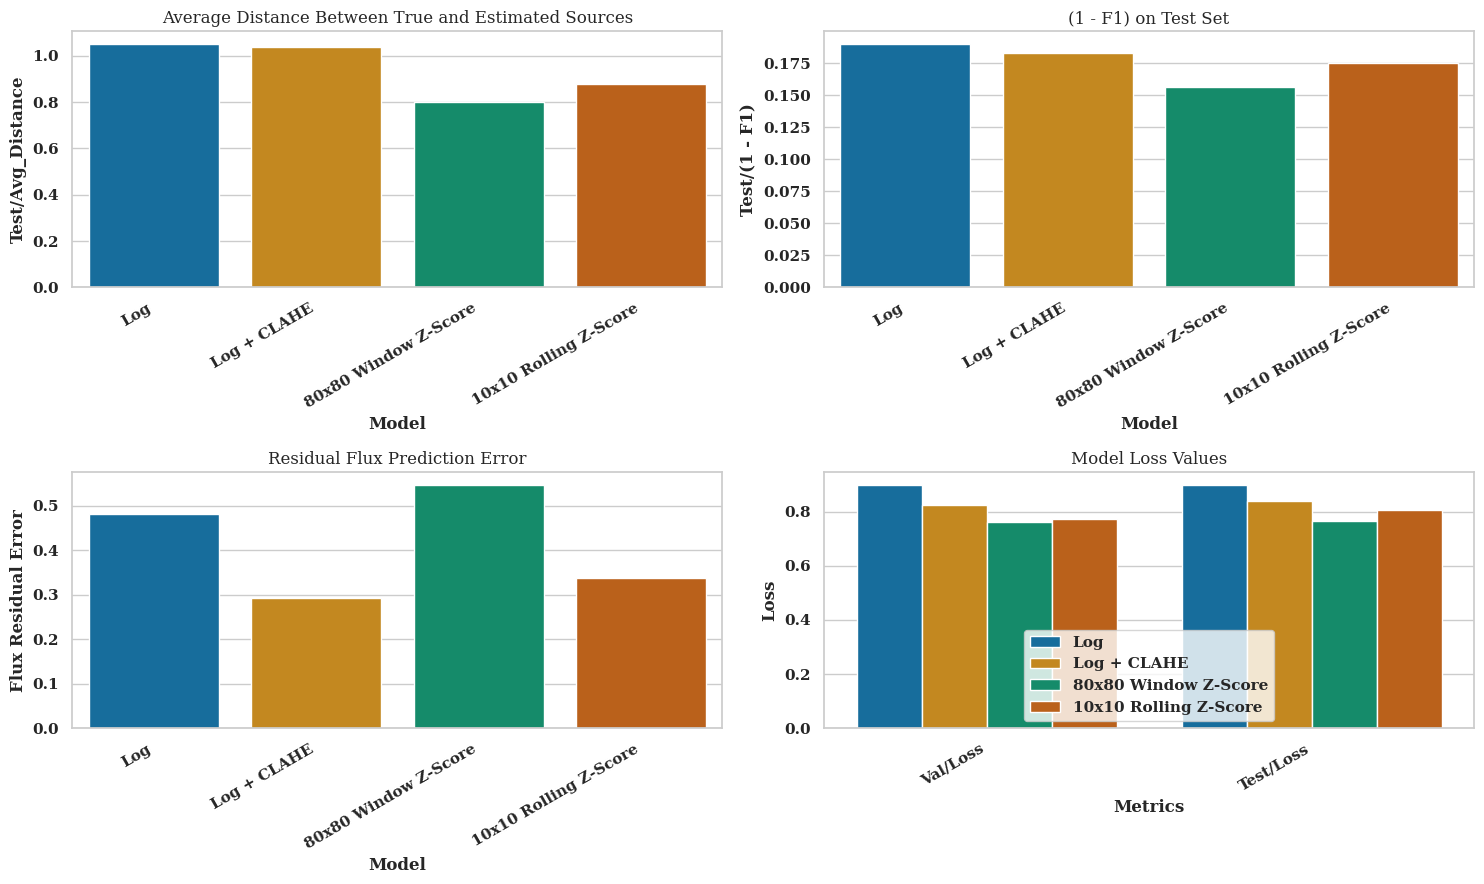

In [202]:
# fig, axes = plt.subplots(2, 2, figsize=(18, 10))
sns.set_theme(style='whitegrid', palette='colorblind', font='serif')
fig = plt.figure(figsize=(15, 9))

ax1 = fig.add_subplot(221)
a = sns.barplot(ax=ax1, x='Model', y='Test/Avg_Distance', data=df)
ax1.set_xticklabels(rotation=30, ha='right', labels=transform_fig)
a.set(title='Average Distance Between True and Estimated Sources')
# plt.close()

ax2 = fig.add_subplot(222)
b = sns.barplot(ax=ax2, x='Model', y='Test/(1 - F1)', data=df)
ax2.set_xticklabels(rotation=30, ha='right', labels=transform_fig)
b.set(title='(1 - F1) on Test Set')
# plt.close()

ax3 = fig.add_subplot(223)
c = sns.barplot(ax=ax3, x='Model', y='Flux Residual Error', data=df)
ax3.set_xticklabels(rotation=30, ha='right', labels=transform_fig)
c.set(title='Residual Flux Prediction Error')
# plt.close()

ax4 = fig.add_subplot(224)
d = sns.barplot(ax=ax4, x='Metrics', y='Loss', data=z, hue='Model')
ax4.set_xticklabels(rotation=30, ha='right', labels=["Val/Loss", "Test/Loss"])
d.set(title='Model Loss Values')
plt.legend(loc='lower center')
# plt.close()

plt.tight_layout()
plt.savefig('input_transform_bar_plot.pdf', format='pdf')

## Light source flux ratios

In [36]:
import pickle as pkl

In [37]:
with open("star_fluxes_multi_field.pkl", 'rb') as f:
    star_fluxes = pkl.load(f)

In [38]:
star_ratios = star_fluxes / star_fluxes[:, 2:3]

In [224]:
star_ratios.min()

1.2361037e-08

In [39]:
log_star_ratios = np.log(star_ratios)

In [257]:
log_star_ratios.shape

(56632, 5)

In [42]:
star_fluxes = pd.DataFrame(data=log_star_ratios)

In [45]:
star_fluxes.columns = ['U/R', 'G/R', 'R/R', 'I/R', 'Z/R']

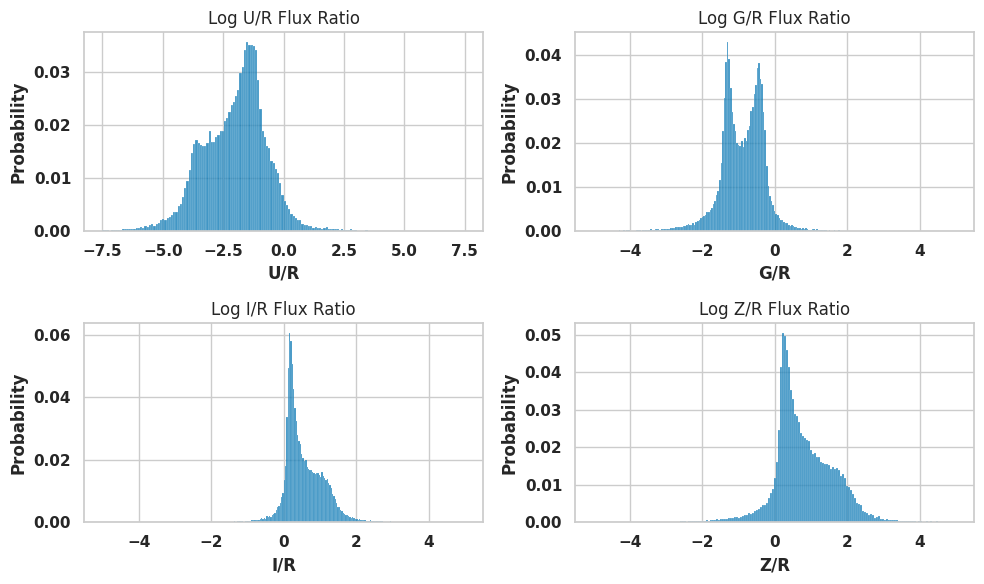

In [47]:
sns.set_theme(style='whitegrid', palette='colorblind')
Fig = plt.figure(figsize=(10, 6))

ax1 = Fig.add_subplot(221)
a = sns.histplot(ax=ax1, x='U/R', data=star_fluxes, binrange=(-7.5, 7.5), stat='probability')
a.set(title='Log U/R Flux Ratio')

ax2 = Fig.add_subplot(222)
b = sns.histplot(ax=ax2, x='G/R', data=star_fluxes, binrange=(-5, 5), stat='probability')
b.set(title='Log G/R Flux Ratio')

ax3 = Fig.add_subplot(223)
c = sns.histplot(ax=ax3, x='I/R', data=star_fluxes, binrange=(-5, 5), stat='probability')
c.set(title='Log I/R Flux Ratio')

ax4 = Fig.add_subplot(224)
d = sns.histplot(ax=ax4, x='Z/R', data=star_fluxes, binrange=(-5, 5), stat='probability')
d.set(title='Log Z/R Flux Ratio')

plt.tight_layout()
plt.savefig('source_flux_ratio_hist.pdf', format='pdf')

## Unaligned/Realigned Images

In [175]:
sim = instantiate(cfg.simulator)
tc = sim.catalog_prior.sample()
image_ids, image_id_indices = sim.randomized_image_ids(sim.catalog_prior.batch_size)

In [176]:
images, psfs, psf_params, wcs_undo = sim.image_decoder.render_images(tc, image_ids)
fc = tc.to_full_params()

In [177]:
img_copy = copy.deepcopy(images)
from bliss.predict import align

for i in range(img_copy.shape[0]):
    img_copy[i] = torch.from_numpy(
        align(
            img_copy[i].numpy(),
            wcs_undo[i],
            sim.catalog_prior.b_band,
        )
    )

In [153]:
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 50}

matplotlib.rc('font', **font)

In [30]:
images.shape

torch.Size([64, 5, 80, 80])

/tmp/ipykernel_1007958/4226525764.py:11: RuntimeWarning: divide by zero encountered in log
  axs[1, i-1].imshow(np.log(img_copy[ind, i]), extent=[0, 80, 80, 0], cmap=cmap)


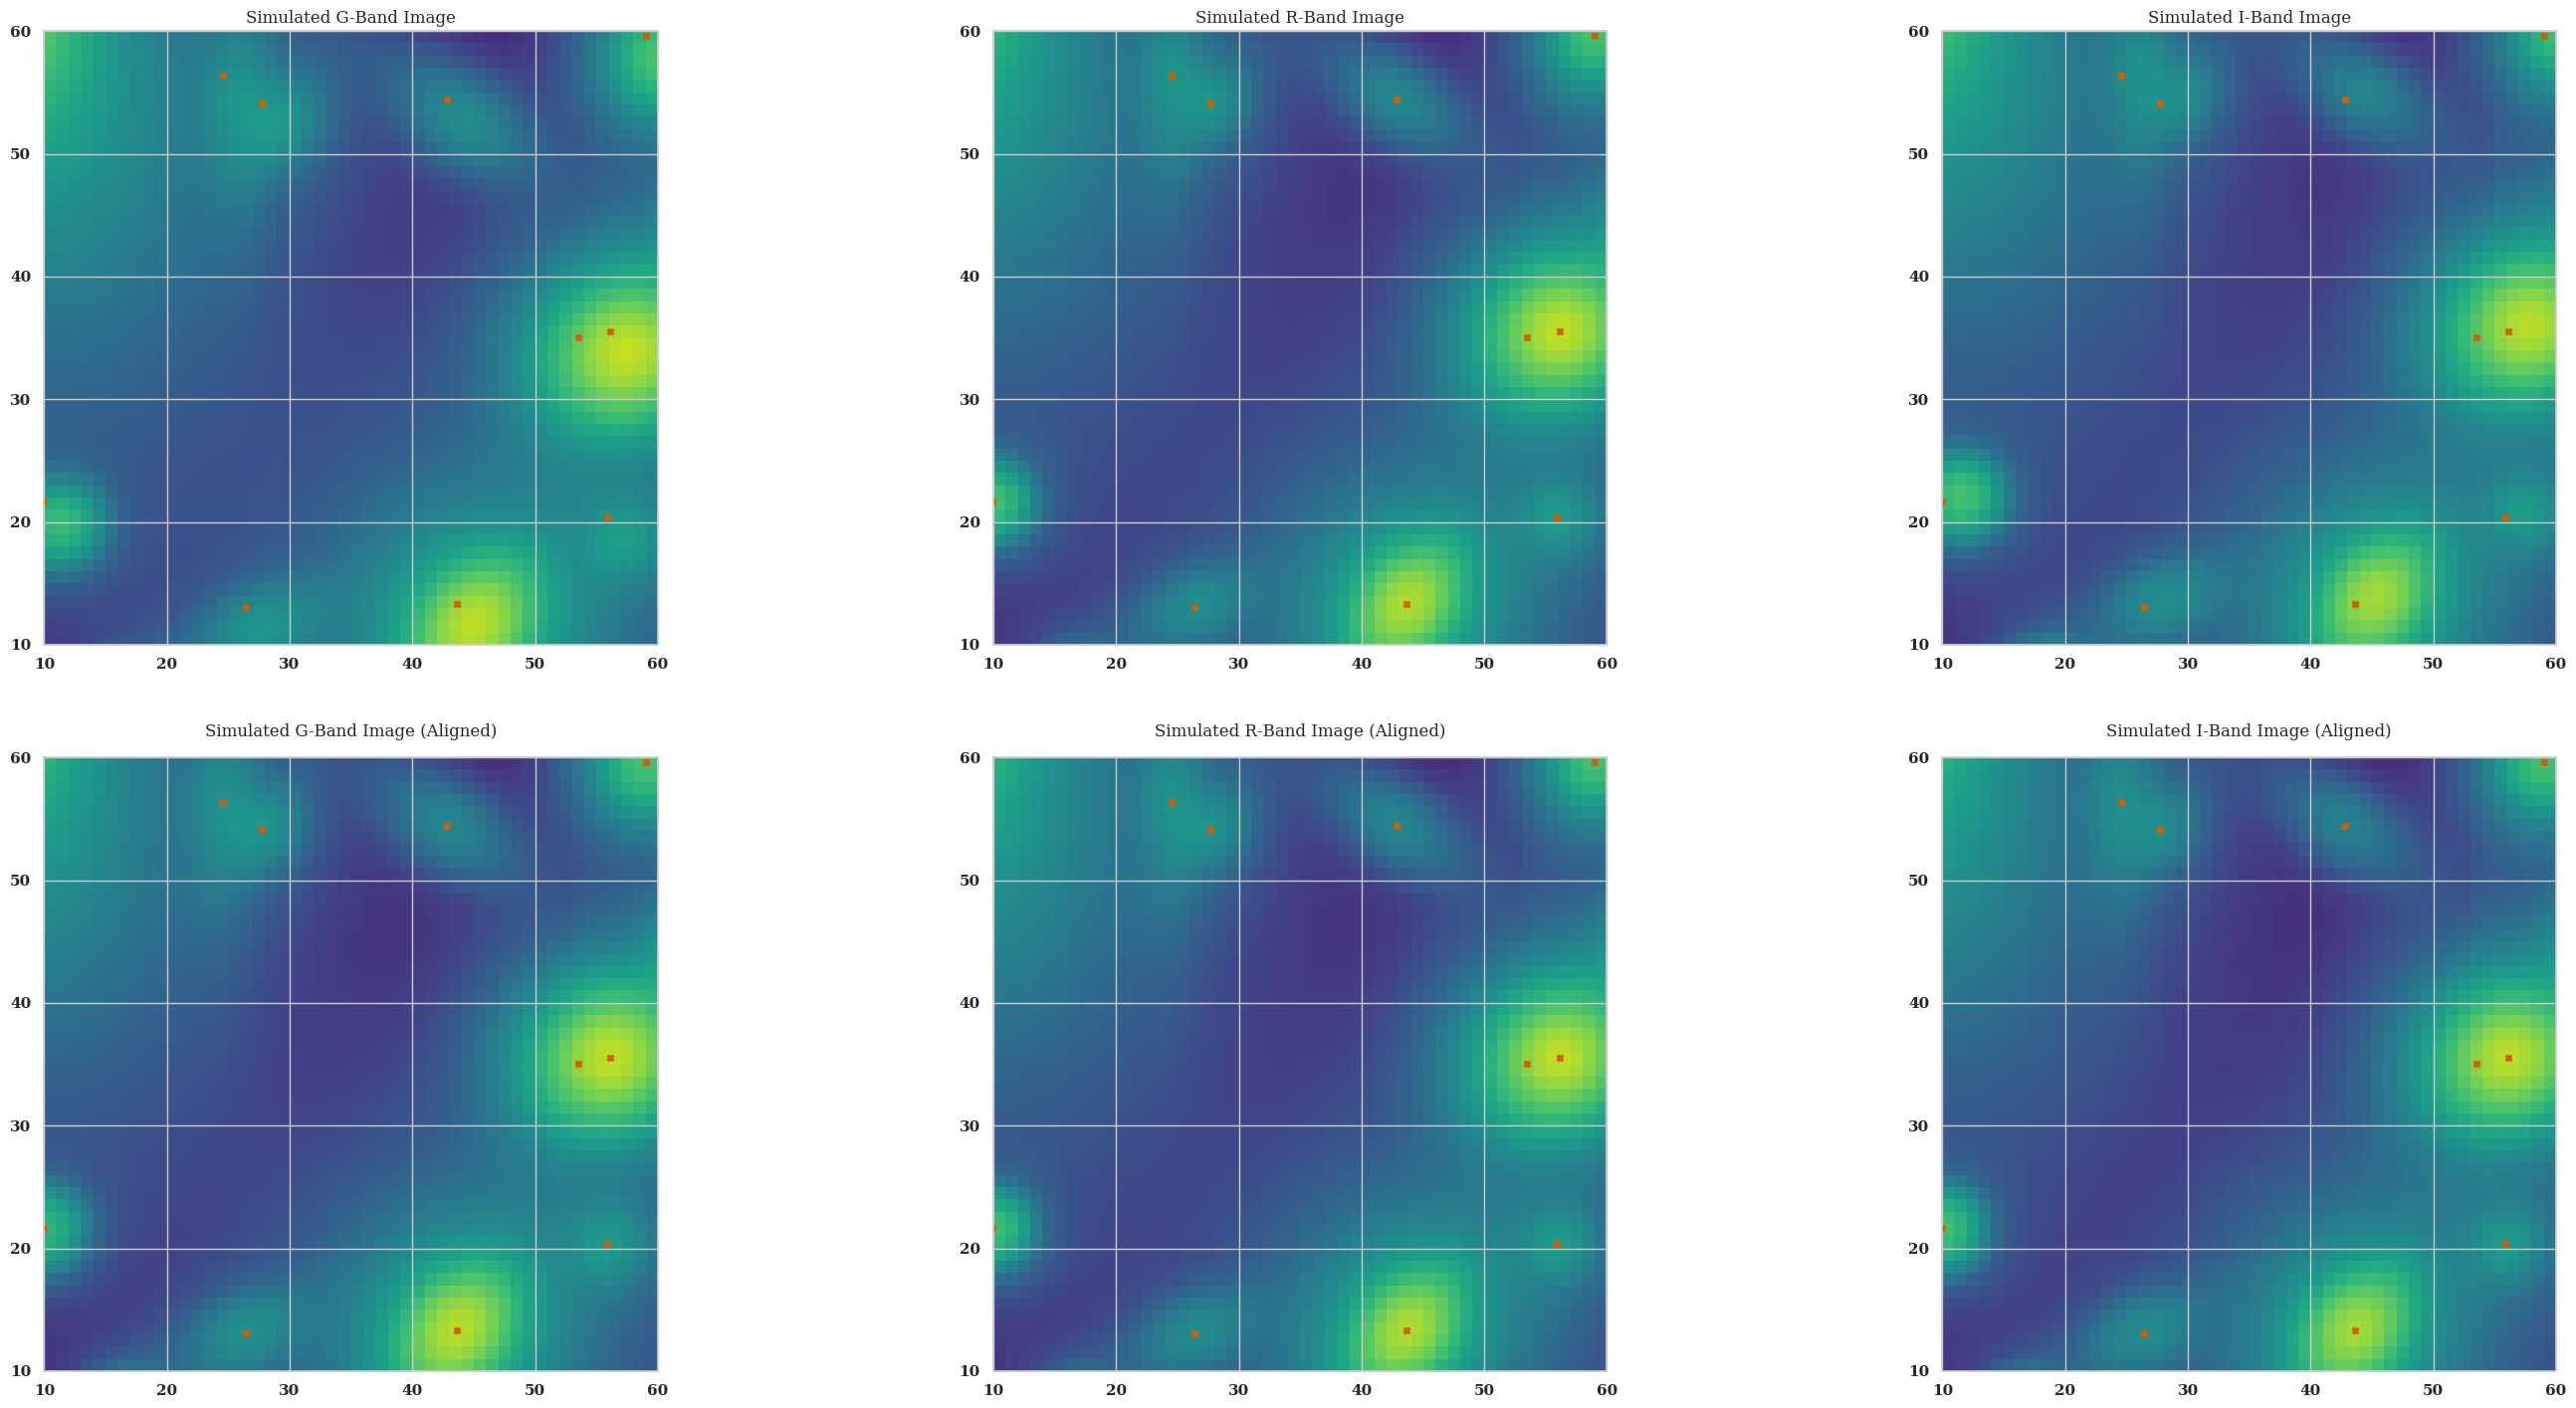

In [192]:
plt.rcParams.update({'font.size': 35})
cmap = 'viridis'
ind = 4
c = 'r'
d = {0: 'U', 1: 'G', 2: 'R', 3: 'I', 4: 'Z'}
fig, axs = plt.subplots(2, 3, figsize=(35, 15))
for i in range(1, 4):
    axs[0, i-1].imshow(np.log(images[ind, i]), extent=[0, 80, 80, 0], cmap=cmap)
    axs[0, i-1].scatter(fc['plocs'][ind, :, 1], fc['plocs'][ind, :, 0], s=20, c=c, marker='X')
    axs[0, i-1].set_title(f'Simulated {d[i]}-Band Image')
    axs[1, i-1].imshow(np.log(img_copy[ind, i]), extent=[0, 80, 80, 0], cmap=cmap)
    axs[1, i-1].scatter(fc['plocs'][ind, :, 1], fc['plocs'][ind, :, 0], s=20, c=c, marker='X')
    axs[1, i-1].set_title(f'Simulated {d[i]}-Band Image (Aligned)', pad=15.0)
    axs[0, i-1].set_xlim(10, 60)
    axs[1, i-1].set_xlim(10, 60)
    axs[0, i-1].set_ylim(10, 60)
    axs[1, i-1].set_ylim(10, 60)
fig.tight_layout()
plt.tight_layout()
# plt.show()
plt.savefig("unaligned_realigned_imgs.pdf", format="pdf")

### Ablation detection figure

In [40]:
def pred(cfg, tile_cat, images, background):
    """Compute predictions using BLISS predict pipeline.
        Inputs:
            cfg: config file
            tile_cat: true tile catalog (not cropped)
            images: simulated images
            background: simulated background
        Output:
            est_tile_cat: estimated tile catalog
    """
    conf = cfg.copy()
    imgs = copy.deepcopy(images)
    bgs = copy.deepcopy(background)
    tc = copy.deepcopy(tile_cat)
    encoder = instantiate(conf.encoder)
    enc_state_dict = torch.load(conf.predict.weight_save_path)
    encoder.load_state_dict(enc_state_dict)
    encoder.eval()
    batch = {"images": imgs, "background": bgs}
    true_tile_cat = tc.symmetric_crop(encoder.tiles_to_crop)
    pred = encoder.encode_batch(batch)
    est_tile_cat = encoder.variational_mode(pred, return_full=False)
    return est_tile_cat

In [41]:
def create_df(key, d, steps):
    """Construct detection metrics dataframe for plotting.
    Inputs:
        d: dictionary with following keys: 
            tgs:
            tss:
            egs:
            ess:
            boot_precision_25
            boot_precision_75
            boot_recall_25
            boot_recall_75
            prec
            rec
    Output:
        df: Pandas dataframe containing above data
    """
    metrics = {}
    for i in range(len(d[key]['tgs'])):
        if 'tgs' not in metrics.keys():
            metrics['tgs'] = []
        metrics['tgs'].append(d[key]['tgs'][i].numpy())    
    for i in range(len(d[key]['tss'])):
        if 'tss' not in metrics.keys():
            metrics['tss'] = []
        metrics['tss'].append(d[key]['tss'][i].numpy())    
    for i in range(len(d[key]['egs'])):
        if 'egs' not in metrics.keys():
            metrics['egs'] = []
        metrics['egs'].append(d[key]['egs'][i].numpy())   
    for i in range(len(d[key]['ess'])):
        if 'ess' not in metrics.keys():
            metrics['ess'] = []
        metrics['ess'].append(d[key]['ess'][i].numpy())    
    for i in range(len(d[key]['boot_precision_25'])):
        if 'boot_precision_25' not in metrics.keys():
            metrics['boot_precision_25'] = d[key]['boot_precision_25']
    for i in range(len(d[key]['boot_precision_75'])):
        if 'boot_precision_75' not in metrics.keys():
            metrics['boot_precision_75'] = d[key]['boot_precision_75']
    for i in range(len(d[key]['boot_recall_25'])):
        if 'boot_recall_25' not in metrics.keys():
            metrics['boot_recall_25'] = d[key]['boot_recall_25']
    for i in range(len(d[key]['boot_recall_75'])):
        if 'boot_recall_75' not in metrics.keys():
            metrics['boot_recall_75'] = d[key]['boot_recall_75']
    for i in range(len(d[key]['prec'])):
        if 'prec' not in metrics.keys():
            metrics['prec'] = d[key]['prec']
    for i in range(len(d[key]['rec'])):
        if 'rec' not in metrics.keys():
            metrics['rec'] = d[key]['rec']
    df = pd.DataFrame(metrics)
    df['Max R-Flux (Log-10)'] = steps
    df = df.rename(columns={"detection_precision": "Precision", "detection_recall": "Recall", "f1": "F-1"})
    return df

In [42]:
# Generate
sim = instantiate(cfg.simulator)
tc = sim.catalog_prior.sample()
image_ids, image_id_indices = sim.randomized_image_ids(sim.catalog_prior.batch_size)
images, background, deconv, psf_params, tile_c = sim.simulate_image(
    tc, image_ids, image_id_indices
)

In [44]:
# Save simulated data for reproducibility
with open('binning_test_data.pkl', 'wb') as f:
    pkl.dump(test_data, f)

In [45]:
# Crop true tile catalog
true_tile_cat = tile_c.symmetric_crop(cfg.encoder.tiles_to_crop)

In [46]:
d = {"vectorized_rolling_z_r.pt": {"bands": [2], "est_tile_cat": None}, "vectorized_rolling_z_gri.pt": {"bands": [1, 2, 3], "est_tile_cat": None}, "vectorized_rolling_z.pt": {"bands": [0, 1, 2, 3, 4], "est_tile_cat": None}}
for model in d.keys():
    cfg.encoder.bands = d[model]["bands"]
    cfg.predict.weight_save_path = "/data/scratch/sawanpa/paper_models/" + model
    d[model]["est_tile_cat"] = pred(cfg, tile_c, images, background)

In [ ]:
def construct_pred_dict(cfg, fpaths, bands):
    d = {}
    for i in range(len(fpaths)):
        d[fpaths[i]] = {"bands": bands[i], "est_tile_cat": None}
        conf = cfg.copy()
        conf.encoder.bands = bands[i]
        conf.predict.weight_save_path += fpaths[i]
        d[fpaths[i]]['est_tile_cat'] = pred(conf, tile)
    return d

In [ ]:
fnames = ["vectorized_rolling_z_r.pt", "vectorized_rolling_z_gri.pt", "vectorized_rolling_z_r.pt"]
bands = [[0, 1, 2, 3, 4], [1, 2, 3], [2]]
d = construct_pred_dict(cfg, fnames, bands)

In [47]:
# Save off prediction results

with open('model_preds.pkl', 'wb') as f:
    pkl.dump(d, f)
with open('true_cat.pkl', 'wb') as f:
    pkl.dump(true_tile_cat, f)

In [9]:
# Load back prediction results

with open('model_preds.pkl', 'rb') as f:
    d = pkl.load(f)
with open('true_cat.pkl', 'rb') as f:
    true_tile_cat = pkl.load(f)

In [49]:
# Generate bin-intervals for histogram
steps = np.logspace(3, 6, num=12)  # fluxes
bins = np.array([np.array([steps[i], steps[i+1]]) for i in range(len(steps) - 1)])

In [51]:
# Instantiate metrics object
metrics = BlissMetrics(survey_bands = [0, 1, 2, 3, 4], mode=MetricsMode.TILE)

In [67]:
def detection_dfs(d, steps, true_tile_cat):
    """Creates dataframes for each tested model populated with detection metrics.
    Inputs:
        d: dictionary output from <construct_pred_dict>
        steps: vector containing bin start points
        true_tile_cat: true tile catalog used for computing model predictions
    Output:
        df_d: dictionary containing each model's detection dataframe"""

    for model in d.keys():
        tc_cat_est = d[model]['est_tile_cat']
        tc_cat_true = true_tile_cat
        d[model]['tgs'] = []
        d[model]['tss'] = []
        d[model]['egs'] = []
        d[model]['ess'] = []
        d[model]['boot_precision'] = []
        d[model]['boot_recall'] = []
        d[model]['prec'] = []
        d[model]['rec'] = []
        for j in range(len(steps[:-1])):

            # COMPUTE RECALL
            tc_cat_true_mod = tc_cat_true.filter_tile_catalog_by_flux(steps[j], steps[j+1])
            tc_cat_est_mod = TileCatalog(4, tc_cat_est.to_dict())
            tc_cat_est_mod.n_sources = tc_cat_true_mod.n_sources
            d[model]['rec'].append(metrics(tc_cat_true_mod, tc_cat_est_mod)['detection_recall'])
            # COMPUTE PRECISION
            tc_cat_est_mod = tc_cat_est.filter_tile_catalog_by_flux(steps[j], steps[j+1])
            tc_cat_true_mod = TileCatalog(4, tc_cat_true.to_dict())
            tc_cat_true_mod.n_sources = tc_cat_est_mod.n_sources
            d[model]['prec'].append(metrics(tc_cat_true_mod, tc_cat_est_mod)['detection_precision'])
            true_sources = copy.deepcopy(tc_cat_true_mod.star_bools + tc_cat_true_mod.galaxy_bools)
            est_sources = copy.deepcopy(tc_cat_est_mod.star_bools + tc_cat_est_mod.galaxy_bools)
            d[model]['tgs'].append(tc_cat_true_mod.galaxy_bools.sum())
            d[model]['tss'].append(tc_cat_true_mod.star_bools.sum())
            d[model]['egs'].append(tc_cat_est_mod.galaxy_bools.sum())
            d[model]['ess'].append(tc_cat_est_mod.star_bools.sum())


        # Perform bootstrapping
        true_sources = copy.deepcopy(tc_cat_true.star_bools + tc_cat_true.galaxy_bools)
        est_sources = copy.deepcopy(tc_cat_est.star_bools + tc_cat_est.galaxy_bools)
        n_boots = 10
        n_matches = 1024 # len(tc_cat_true['star_fluxes'])
        n_bins = len(steps) - 1
        boot_precision = np.zeros((n_boots, n_bins))
        boot_recall = np.zeros((n_boots, n_bins))

        boot_indices = np.random.randint(0, n_matches, (n_boots, n_matches))

        # compute boostrap precision and recall per bin
        for ii in range(n_boots):
            tc_cat_true_boot = copy.deepcopy(tc_cat_true)
            tc_cat_est_boot = TileCatalog(4, tc_cat_est.to_dict())
            d_true = {}
            d_est = {}
            for key, _ in tc_cat_true_boot.to_dict().items():
                d_true[key] = tc_cat_true[key][boot_indices[ii]]
                d_est[key] = tc_cat_est[key][boot_indices[ii]]
            tc_cat_true_boot = TileCatalog(4, d_true)
            tc_cat_est_boot = TileCatalog(4, d_est)
            for jj, (b1, b2) in enumerate(bins):

                # COMPUTE BOOT RECALL
                tc_cat_true_boot_bin = copy.deepcopy(tc_cat_true_boot)
                tc_cat_true_boot_bin = tc_cat_true_boot.filter_tile_catalog_by_flux(b1, b2)
                tc_cat_est_boot_bin = TileCatalog(4, tc_cat_est_boot.to_dict())
                tc_cat_est_boot_bin.n_sources = tc_cat_true_boot_bin.n_sources
                m = metrics(tc_cat_true_boot_bin, tc_cat_est_boot_bin)
                r = m['detection_recall']
                # COMPUTE BOOT PRECISION
                tc_cat_est_boot_bin = tc_cat_est_boot.filter_tile_catalog_by_flux(b1, b2)
                tc_cat_true_boot_bin = TileCatalog(4, tc_cat_true_boot.to_dict())
                tc_cat_true_boot_bin.n_sources = tc_cat_est_boot_bin.n_sources
                m = metrics(tc_cat_true_boot_bin, tc_cat_est_boot_bin)      
                p = m['detection_precision']

                boot_precision[ii][jj] = p
                boot_recall[ii][jj] = r
        d[model]['boot_precision'].append(boot_precision)
        d[model]['boot_recall'].append(boot_recall)

    for model in d.keys():
        boot_precision = d[model]['boot_precision'].pop()
        boot_recall = d[model]['boot_recall'].pop()
        d[model]['boot_precision_25'] = []
        d[model]['boot_recall_25'] = []
        d[model]['boot_precision_75'] = []
        d[model]['boot_recall_75'] = []

        for i in range(len(steps[1:])):
            d[model]['boot_precision_25'].append(np.quantile(boot_precision[:, i], 0.25))
            d[model]['boot_recall_25'].append(np.quantile(boot_recall[:, i], 0.25))
            d[model]['boot_precision_75'].append(np.quantile(boot_precision[:, i], 0.75))
            d[model]['boot_recall_75'].append(np.quantile(boot_recall[:, i], 0.75))
    
    out_d = {}

    for model in d.keys():
        out_d[model] = create_df(model, d, np.log10(steps[1:]))

    return out_d

In [53]:
for model in d.keys():
    tc_cat_est = d[model]['est_tile_cat']
    tc_cat_true = true_tile_cat
    d[model]['tgs'] = []
    d[model]['tss'] = []
    d[model]['egs'] = []
    d[model]['ess'] = []
    d[model]['boot_precision'] = []
    d[model]['boot_recall'] = []
    d[model]['prec'] = []
    d[model]['rec'] = []
    for j in range(len(steps[:-1])):

        # COMPUTE RECALL
        tc_cat_true_mod = tc_cat_true.filter_tile_catalog_by_flux(steps[j], steps[j+1])
        tc_cat_est_mod = TileCatalog(4, tc_cat_est.to_dict())
        tc_cat_est_mod.n_sources = tc_cat_true_mod.n_sources
        d[model]['rec'].append(metrics(tc_cat_true_mod, tc_cat_est_mod)['detection_recall'])
        # COMPUTE PRECISION
        tc_cat_est_mod = tc_cat_est.filter_tile_catalog_by_flux(steps[j], steps[j+1])
        tc_cat_true_mod = TileCatalog(4, tc_cat_true.to_dict())
        tc_cat_true_mod.n_sources = tc_cat_est_mod.n_sources
        d[model]['prec'].append(metrics(tc_cat_true_mod, tc_cat_est_mod)['detection_precision'])
        true_sources = copy.deepcopy(tc_cat_true_mod.star_bools + tc_cat_true_mod.galaxy_bools)
        est_sources = copy.deepcopy(tc_cat_est_mod.star_bools + tc_cat_est_mod.galaxy_bools)
        d[model]['tgs'].append(tc_cat_true_mod.galaxy_bools.sum())
        d[model]['tss'].append(tc_cat_true_mod.star_bools.sum())
        d[model]['egs'].append(tc_cat_est_mod.galaxy_bools.sum())
        d[model]['ess'].append(tc_cat_est_mod.star_bools.sum())


    # Perform bootstrapping
    true_sources = copy.deepcopy(tc_cat_true.star_bools + tc_cat_true.galaxy_bools)
    est_sources = copy.deepcopy(tc_cat_est.star_bools + tc_cat_est.galaxy_bools)
    n_boots = 10
    n_matches = 1024 # len(tc_cat_true['star_fluxes'])
    n_bins = len(steps) - 1
    boot_precision = np.zeros((n_boots, n_bins))
    boot_recall = np.zeros((n_boots, n_bins))

    boot_indices = np.random.randint(0, n_matches, (n_boots, n_matches))

    # compute boostrap precision and recall per bin
    for ii in range(n_boots):
        tc_cat_true_boot = copy.deepcopy(tc_cat_true)
        tc_cat_est_boot = TileCatalog(4, tc_cat_est.to_dict())
        d_true = {}
        d_est = {}
        for key, _ in tc_cat_true_boot.to_dict().items():
            d_true[key] = tc_cat_true[key][boot_indices[ii]]
            d_est[key] = tc_cat_est[key][boot_indices[ii]]
        tc_cat_true_boot = TileCatalog(4, d_true)
        tc_cat_est_boot = TileCatalog(4, d_est)
        for jj, (b1, b2) in enumerate(bins):

            # COMPUTE BOOT RECALL
            tc_cat_true_boot_bin = copy.deepcopy(tc_cat_true_boot)
            tc_cat_true_boot_bin = tc_cat_true_boot.filter_tile_catalog_by_flux(b1, b2)
            tc_cat_est_boot_bin = TileCatalog(4, tc_cat_est_boot.to_dict())
            tc_cat_est_boot_bin.n_sources = tc_cat_true_boot_bin.n_sources
            m = metrics(tc_cat_true_boot_bin, tc_cat_est_boot_bin)
            r = m['detection_recall']
            # COMPUTE BOOT PRECISION
            tc_cat_est_boot_bin = tc_cat_est_boot.filter_tile_catalog_by_flux(b1, b2)
            tc_cat_true_boot_bin = TileCatalog(4, tc_cat_true_boot.to_dict())
            tc_cat_true_boot_bin.n_sources = tc_cat_est_boot_bin.n_sources
            m = metrics(tc_cat_true_boot_bin, tc_cat_est_boot_bin)      
            p = m['detection_precision']

            boot_precision[ii][jj] = p
            boot_recall[ii][jj] = r
    d[model]['boot_precision'].append(boot_precision)
    d[model]['boot_recall'].append(boot_recall)

In [54]:
for model in d.keys():
    boot_precision = d[model]['boot_precision'].pop()
    boot_recall = d[model]['boot_recall'].pop()
    d[model]['boot_precision_25'] = []
    d[model]['boot_recall_25'] = []
    d[model]['boot_precision_75'] = []
    d[model]['boot_recall_75'] = []
    for i in range(boot_precision.shape[1]):
        d[model]['boot_precision_25'].append(np.quantile(boot_precision[:, i], 0.25))
        d[model]['boot_recall_25'].append(np.quantile(boot_recall[:, i], 0.25))
        d[model]['boot_precision_75'].append(np.quantile(boot_precision[:, i], 0.75))
        d[model]['boot_recall_75'].append(np.quantile(boot_recall[:, i], 0.75))

In [68]:
out_d = detection_dfs(d, steps, true_tile_cat)

In [55]:
whole_df = create_df("vectorized_rolling_z.pt", d, np.log10(steps[1:]))
gri_df = create_df("vectorized_rolling_z_gri.pt", d, np.log10(steps[1:]))
r_df = create_df("vectorized_rolling_z_r.pt", d, np.log10(steps[1:]))

In [71]:
r_df, gri_df, whole_df = list(out_d.values())

In [58]:
dfs = [r_df, gri_df, whole_df]
names = ["R", "GRI", "UGRIZ"]

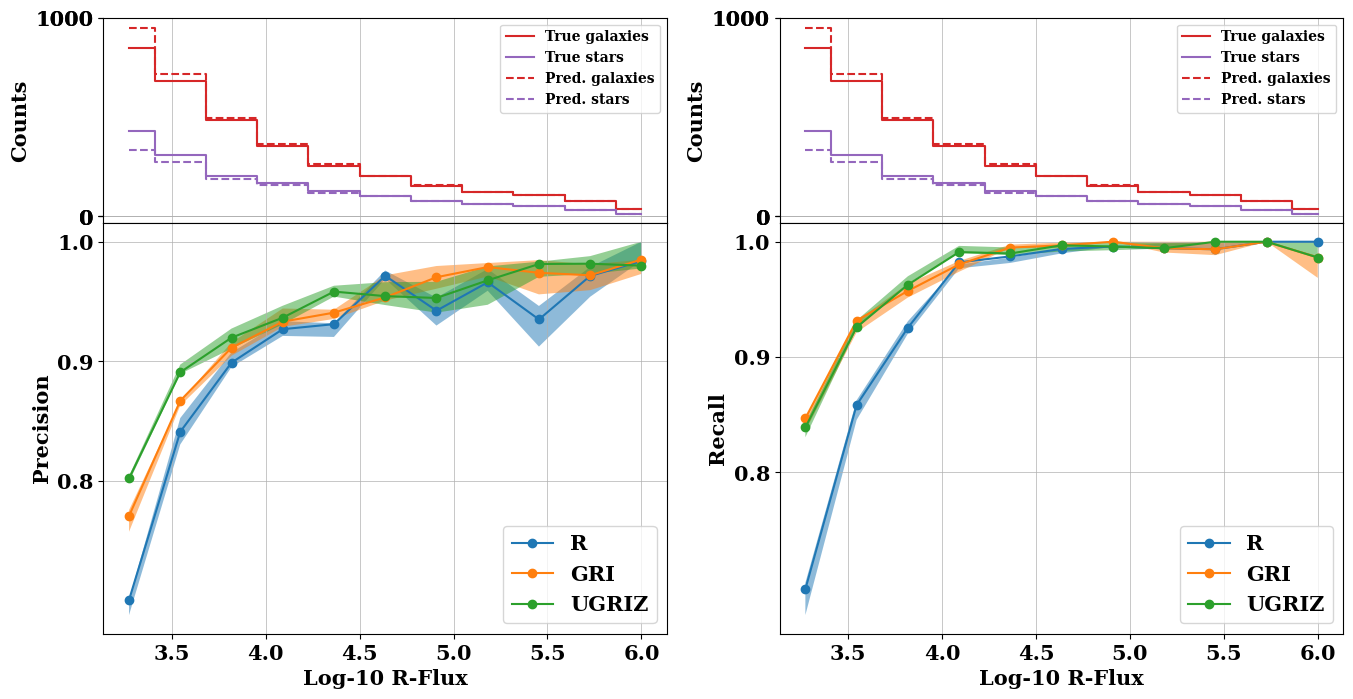

In [65]:
# Generate plot - pass in dfs out_d.values() list (out_d is output from <detection_dfs())

font = {'family' : 'serif',
        'weight' : 'heavy',
        'size'   : 15,
        }

matplotlib.rc('font', **font)
fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(
    2, 2, figsize=(16, 8), gridspec_kw={"height_ratios": [1, 2]}, sharex=True
)
for i, df in enumerate(dfs):

    # params
    xlabel = "Log-10 R-Flux"
    metric_type = "Precision"
    legend_size_hist = 10
    ratio = 2
    where_step = "mid"
    n_ticks = 5
    ordmag = 3

    precision = df["Precision"]
    recall = df["Recall"]
    precision1 = df["boot_precision_25"]
    precision2 = df["boot_precision_75"]
    recall1 = df["boot_recall_25"]
    recall2 = df["boot_recall_75"]
    precision_sd = df['boot_precision_sd']
    recall_sd = df['boot_recall_sd']
    precision_m = df['boot_precision_m']
    recall_m = df['boot_recall_m']
    tgcount = df["tgs"]
    tscount = df["tss"]
    egcount = df["egs"]
    escount = df["ess"]
    prec = df['prec']

    ymin = min(prec.min(), recall.min())
    yticks = np.arange(np.round(ymin, 1), 1.1, 0.1)
    ax2.set_yticks(yticks)
    ax2.plot(np.log10(steps[1:]), prec, "-o", label=f"{names[i]}", markersize=6)
    ax2.fill_between(np.log10(steps[1:]), precision1, precision2, alpha=0.5)
    ax2.legend(loc='best')
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(rf"{metric_type}")
    ax2.set
    ax2.grid(linestyle="-", linewidth=0.5, which="major", axis="both")


# setup histogram plot up top
c1 = plt.rcParams["axes.prop_cycle"].by_key()["color"][3]
c2 = plt.rcParams["axes.prop_cycle"].by_key()["color"][4]
ax1.step(np.log10(steps[1:]), tgcount, label="True galaxies", where=where_step, color=c1)
ax1.step(np.log10(steps[1:]), tscount, label="True stars", where=where_step, color=c2)
ax1.step(np.log10(steps[1:]), egcount, label="Pred. galaxies", ls="--", where=where_step, color=c1)
ax1.step(np.log10(steps[1:]), escount, label="Pred. stars", ls="--", where=where_step, color=c2)
ymax = max(tgcount.max(), tscount.max(), egcount.max(), escount.max())
yticks = np.round(np.linspace(0, ymax, n_ticks), -ordmag)
ax1.set_yticks(yticks)
ax1.set_ylabel(r"Counts")
ax1.legend(loc="best", prop={"size": legend_size_hist})
ax1.grid(linestyle="-", linewidth=0.5, which="major", axis="both")
plt.subplots_adjust(hspace=0)

for i, df in enumerate(dfs):

    # params
    xlabel = "Log-10 R-Flux"
    metric_type = "Recall"
    legend_size_hist = 10
    ratio = 2
    where_step = "mid"
    n_ticks = 5
    ordmag = 3

    precision = df["Precision"]
    recall = df["Recall"]
    precision1 = df["boot_precision_25"]
    precision2 = df["boot_precision_75"]
    recall1 = df["boot_recall_25"]
    recall2 = df["boot_recall_75"]
    precision_sd = df['boot_precision_sd']
    recall_sd = df['boot_recall_sd']
    precision_m = df['boot_precision_m']
    recall_m = df['boot_recall_m']
    tgcount = df["tgs"]
    tscount = df["tss"]
    egcount = df["egs"]
    escount = df["ess"]


    # (bottom) plot of precision and recall
    ymin = min(precision.min(), recall.min())
    yticks = np.arange(np.round(ymin, 1), 1.1, 0.1)
    ax4.set_yticks(yticks)
    # c1 = plt.rcParams["axes.prop_cycle"].by_key()["color"][0]
    ax4.plot(np.log10(steps[1:]), recall, "-o", label=f"{names[i]}", markersize=6)
    ax4.fill_between(np.log10(steps[1:]), recall1, recall2, alpha=0.5)
    ax4.legend(loc='best')
    ax4.set_xlabel(xlabel)
    ax4.set_ylabel(rf"{metric_type}")
    ax4.grid(linestyle="-", linewidth=0.5, which="major", axis="both")

# setup histogram plot up top
c1 = plt.rcParams["axes.prop_cycle"].by_key()["color"][3]
c2 = plt.rcParams["axes.prop_cycle"].by_key()["color"][4]
ax3.step(np.log10(steps[1:]), tgcount, label="True galaxies", where=where_step, color=c1)
ax3.step(np.log10(steps[1:]), tscount, label="True stars", where=where_step, color=c2)
ax3.step(np.log10(steps[1:]), egcount, label="Pred. galaxies", ls="--", where=where_step, color=c1)
ax3.step(np.log10(steps[1:]), escount, label="Pred. stars", ls="--", where=where_step, color=c2)
ymax = max(tgcount.max(), tscount.max(), egcount.max(), escount.max())
yticks = np.round(np.linspace(0, ymax, n_ticks), -ordmag)
ax3.set_yticks(yticks)
ax3.set_ylabel(r"Counts")
ax3.legend(loc="best", prop={"size": legend_size_hist})
ax3.grid(linestyle="-", linewidth=0.5, which="major", axis="both")
plt.subplots_adjust(hspace=0)
plt.show()

In [163]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'b

In [151]:
whole_df['boot_precision_sd']

0     0.037542
1     0.026106
2     0.023662
3     0.038230
4     0.032056
5     0.036980
6     0.062604
7     0.039112
8     0.000000
9     0.000000
10    0.000000
Name: boot_precision_sd, dtype: float64

In [116]:
boot_precision[:, -4]

array([    0.91667,     0.96154,           1,           1,     0.96154,     0.91667,     0.94737,     0.93333,         0.9,        0.96])

In [75]:
whole_df['boot_recall_sd']

0     0.024391
1     0.028634
2     0.035115
3     0.035666
4     0.043988
5     0.047921
6     0.055721
7     0.053192
8     0.074889
9     0.096967
10    0.102082
Name: boot_recall_sd, dtype: float64

[Text(0.5, 1.0, 'Recall for Multi-Band Inference')]

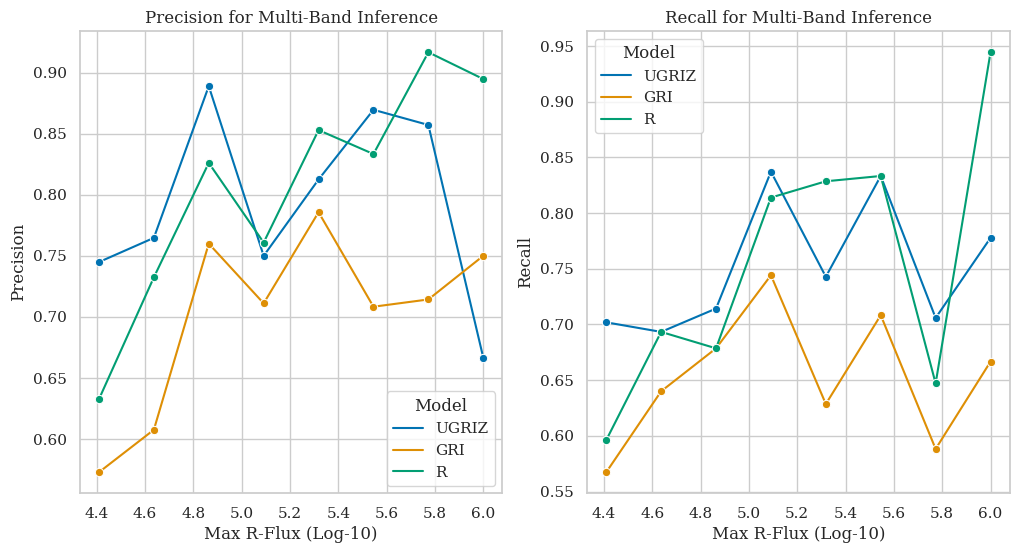

In [195]:
sns.set_theme(style='whitegrid', palette='colorblind', font='serif')
Fig = plt.figure(figsize=(12, 6))

ax1 = Fig.add_subplot(121)
a = sns.lineplot(data=total, x='Max R-Flux (Log-10)', y='Precision', hue='Model', marker='o', dashes=True, ax=ax1)
# ax1.errorbar(total['Max R-Flux (Log-10)'].to_numpy(), total['Precision'].to_numpy(), yerr=np.subtract(total['boot_precision_75'].to_numpy(), total['boot_precision_25'].to_numpy()))
a.set(title='Precision for Multi-Band Inference')

ax2 = Fig.add_subplot(122)
b = sns.lineplot(data=total, x='Max R-Flux (Log-10)', y='Recall', hue='Model', marker='o', dashes=True, ax=ax2)
# ax2.errorbar(total['Max R-Flux (Log-10)'].to_numpy(), total['Recall'].to_numpy(), yerr=np.subtract(total['boot_recall_75'].to_numpy(), total['boot_recall_25'].to_numpy()))
b.set(title='Recall for Multi-Band Inference')
# plt.savefig('Ablation_PR_fig.pdf', format='pdf')

## Mendoza et al. (2023) Detection/Classification Figures

In [4]:
from typing import Dict, List, Tuple

In [5]:
whole_df_dict = {'precision': np.array(whole_df['Precision']), 'recall': np.array(whole_df['Recall']), 'tgcount': np.array(whole_df['tgs']), 'tscount': np.array(whole_df['tss']), 'egcount': np.array(whole_df['egs']), 'escount': np.array(whole_df['ess'])}

NameError: name 'whole_df' is not defined

In [164]:
def _make_pr_figure(
    bins: np.ndarray,
    data: Dict[str, np.ndarray],
    xlabel: str,
    xlims: Tuple[float, float] = None,
    ylims: Tuple[float, float] = None,
    ylims2: Tuple[float, float] = None,
    ratio: float = 2,
    where_step: str = "mid",
    n_ticks: int = 5,
    ordmag: int = 3,
    metric_type: str = "Detection",
    legend_size_hist: int = 10,
):
    precision = data["precision"]
    recall = data["recall"]
    boot_precision = data["boot"]["precision"]
    boot_recall = data["boot"]["recall"]
    tgcount = data["tgcount"]
    tscount = data["tscount"]
    egcount = data["egcount"]
    escount = data["escount"]

    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(10, 10), gridspec_kw={"height_ratios": [1, ratio]}, sharex=True
    )

    # (bottom) plot of precision and recall
    ymin = min(precision.min(), recall.min())
    yticks = np.arange(np.round(ymin, 1), 1.1, 0.1)
    c1 = plt.rcParams["axes.prop_cycle"].by_key()["color"][0]
    precision1 = np.quantile(boot_precision, 0.25, 0)
    precision2 = np.quantile(boot_precision, 0.75, 0)
    ax2.plot(bins, precision, "-o", color=c1, label=r"Precision", markersize=6)
    ax2.fill_between(bins, precision1, precision2, color=c1, alpha=0.5)

    c2 = plt.rcParams["axes.prop_cycle"].by_key()["color"][1]
    recall1 = np.quantile(boot_recall, 0.25, 0)
    recall2 = np.quantile(boot_recall, 0.75, 0)
    ax2.plot(bins, recall, "-o", color=c2, label=r"Recall", markersize=6)
    ax2.fill_between(bins, recall1, recall2, color=c2, alpha=0.5)

    ax2.legend()
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(rf"{metric_type} Metric")
    ax2.set_yticks(yticks)
    ax2.grid(linestyle="-", linewidth=0.5, which="major", axis="both")

    if xlims is not None:
        ax2.set_xlim(xlims)
    if ylims is not None:
        ax2.set_ylim(ylims)
    if ylims2 is not None:
        ax1.set_ylim(ylims2)

    # setup histogram plot up top
    c1 = plt.rcParams["axes.prop_cycle"].by_key()["color"][3]
    c2 = plt.rcParams["axes.prop_cycle"].by_key()["color"][4]
    ax1.step(bins, tgcount, label="True galaxies", where=where_step, color=c1)
    ax1.step(bins, tscount, label="True stars", where=where_step, color=c2)
    ax1.step(bins, egcount, label="Pred. galaxies", ls="--", where=where_step, color=c1)
    ax1.step(bins, escount, label="Pred. stars", ls="--", where=where_step, color=c2)
    ymax = max(tgcount.max(), tscount.max(), egcount.max(), escount.max())
    yticks = np.round(np.linspace(0, ymax, n_ticks), -ordmag)
    ax1.set_yticks(yticks)
    ax1.set_ylabel(r"Counts")
    ax1.legend(loc="best", prop={"size": legend_size_hist})
    ax1.grid(linestyle="-", linewidth=0.5, which="major", axis="both")
    plt.subplots_adjust(hspace=0)
    return fig

NameError: name 'Dict' is not defined

In [167]:
np.log10(steps)

array([       2.75,      3.0455,      3.3409,      3.6364,      3.9318,      4.2273,      4.5227,      4.8182,      5.1136,      5.4091,      5.7045,           6])

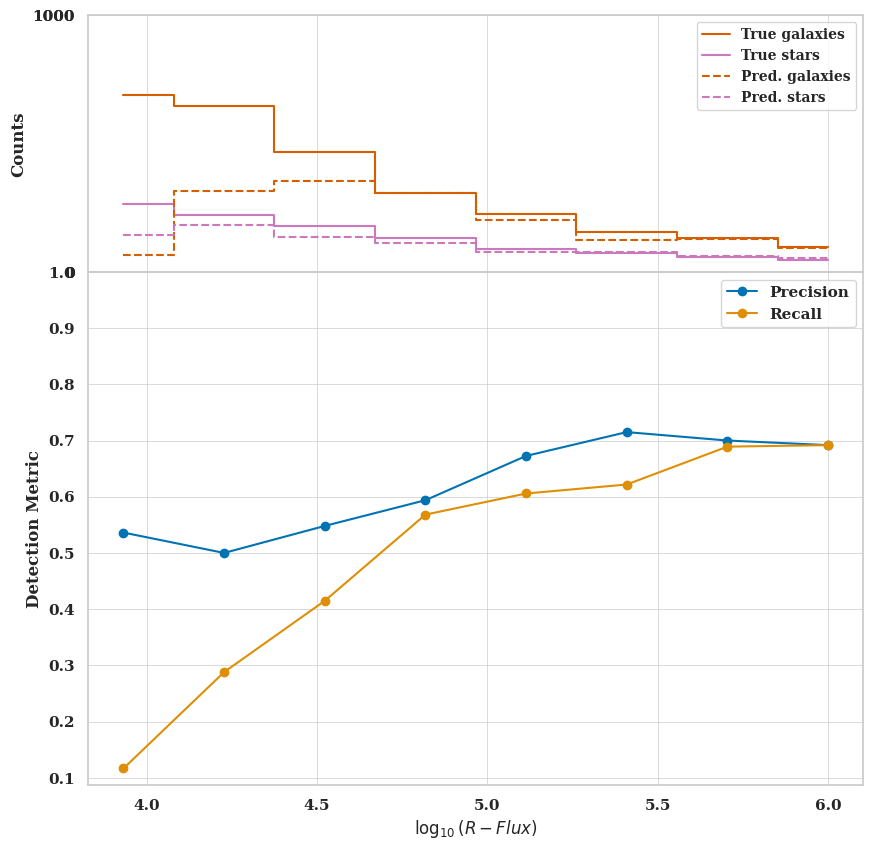

In [344]:
fig = _make_pr_figure(np.log10(steps[4:]), whole_df_dict, r"$\log_{10} (R-Flux)$")
# plt.savefig('Ismael_PR_fig_rep.pdf', format='pdf')

In [204]:
from matplotlib.figure import Figure

In [352]:
def _compute_pr(tgbool: np.ndarray, egbool: np.ndarray):
    t = np.sum(tgbool)
    p = np.sum(egbool)

    cond1 = np.equal(tgbool, egbool).astype(bool)
    cond2 = tgbool.astype(bool)
    tp = (cond1 & cond2).astype(float).sum()

    assert np.all(np.greater_equal(t, tp))
    assert np.all(np.greater_equal(p, tp))
    if t == 0 or p == 0:
        return np.nan, np.nan

    return tp / p, tp / t

def create_figure(data) -> Figure:
    snrs, tgbools, egbools = data["classification"].values()
    snr_bins = data["detection"]["bins"]
    n_matches = len(snrs)
    n_bins = len(snr_bins)
    n_boots = 1000

    precision = np.zeros(n_bins)
    recall = np.zeros(n_bins)
    tgals = np.zeros(n_bins)
    egals = np.zeros(n_bins)
    tstars = np.zeros(n_bins)
    estars = np.zeros(n_bins)

    boot_precision = np.zeros((n_boots, n_bins))
    boot_recall = np.zeros((n_boots, n_bins))

    boot_indices = np.random.randint(0, n_matches, (n_boots, n_matches))

    # compute boostrap precision and recall per bin
    for ii in range(n_boots):
        snrs_ii = snrs[boot_indices[ii]]
        tgbools_ii = tgbools[boot_indices[ii]]
        egbools_ii = egbools[boot_indices[ii]]
        for jj, (b1, b2) in enumerate(snr_bins):
            keep = (b1 < snrs_ii) & (snrs_ii < b2)
            tgbool_ii = tgbools_ii[keep]
            egbool_ii = egbools_ii[keep]

            p, r = _compute_pr(tgbool_ii, egbool_ii)
            boot_precision[ii][jj] = p
            boot_recall[ii][jj] = r

    # compute precision and recall per bin
    for jj, (b1, b2) in enumerate(snr_bins):
        keep = (b1 < snrs) & (snrs < b2)
        tgbool = tgbools[keep]
        egbool = egbools[keep]
        p, r = _compute_pr(tgbool, egbool)
        precision[jj] = p
        recall[jj] = r

        tgals[jj] = tgbool.sum()
        egals[jj] = egbool.sum()
        tstars[jj] = (~tgbool.astype(bool)).astype(float).sum()
        estars[jj] = (~egbool.astype(bool)).astype(float).sum()

    bins = np.log10(snr_bins.mean(1))
    data = {
        "precision": precision,
        "recall": recall,
        "tgcount": tgals,
        "egcount": egals,
        "tscount": tstars,
        "escount": estars,
        "boot": {"precision": boot_precision, "recall": boot_recall},
    }
    return _make_pr_figure(
        bins,
        data,
        r"$\log_{10} \rm (R-Flux)$",
        metric_type="Galaxy Classification",
        legend_size_hist=12,
    )

In [255]:
bins = np.array([np.array([steps[i], steps[i+1]]) for i in range(4, len(steps) - 1)])

In [348]:
di = {"detection": {"bins": bins}, "classification": {"snrs": ((true_tile_cat['star_fluxes']*true_tile_cat.star_bools)[:, :, :, :, 2:3] + (true_tile_cat['galaxy_fluxes']*true_tile_cat.galaxy_bools)[:, :, :, :, 2:3]).numpy(), "tgbools": true_tile_cat.galaxy_bools.numpy(), "egbools": d['vectorized_rolling_z.pt']['est_tile_cat'].galaxy_bools.numpy()}}

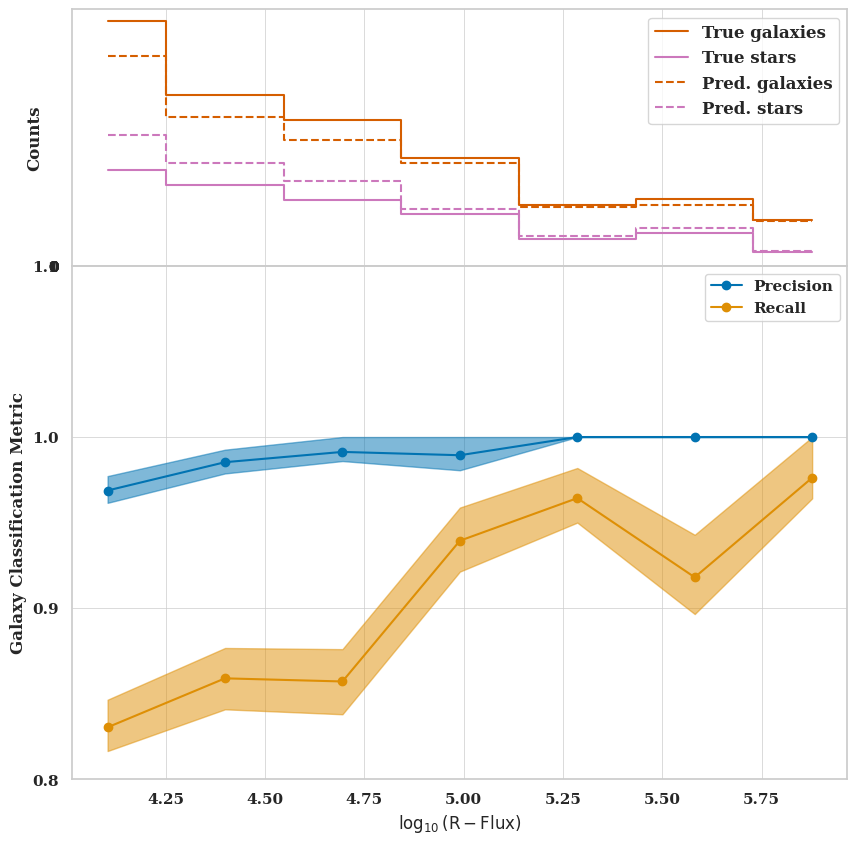

In [354]:
fig = create_figure(di)
plt.savefig('Ismael_Galaxy_Classification_rep.pdf', format='pdf')